In [1]:
# load tensorboard extension
# we will need this later in the notebook to monitor the training progress
%load_ext tensorboard

In [11]:
import numpy as np
import torch.nn as nn
import torch_em
import torch_em.data.datasets as torchem_data
from torch_em.model import AnisotropicUNet
from torch_em.util.debug import check_loader, check_trainer

from pathlib import Path

# Training data

In [23]:
train_data_paths = "/scratch/buglakova/F107_bin2_619-639_predictions/full_raw.n5"
data_key = "raw/raw_data"
train_label_paths = "/scratch/buglakova/3D_UNet_data/ground_truth_labels_CZXY.n5"
label_key = "labels/out_boundary_extra_fg"

# In addition you can also specify region of interests for training using the normal python slice syntax
train_rois = np.s_[586:658, :, :]
val_rois = np.s_[534:598, :, :]

#
# choose the patch shape
#
patch_shape = (32, 256, 256)


In [25]:
def check_data(data_paths, label_paths, rois):
    print("Loading the raw data from:", data_paths, data_key)
    print("Loading the labels from:", label_paths, label_key)
    try:
        torch_em.default_segmentation_dataset(data_paths, data_key, label_paths, label_key, patch_shape, rois=rois, with_label_channels=True)
    except Exception as e:
        print("Loading the dataset failed with:")
        raise e

print("Checking the training dataset:")
check_data(train_data_paths, train_label_paths, train_rois)
check_data(train_data_paths, train_label_paths, val_rois)

assert len(patch_shape) == 3

Checking the training dataset:
Loading the raw data from: /scratch/buglakova/F107_bin2_619-639_predictions/full_raw.n5 raw/raw_data
Loading the labels from: /scratch/buglakova/3D_UNet_data/ground_truth_labels_CZXY.n5 labels/out_boundary_extra_fg
Loading the raw data from: /scratch/buglakova/F107_bin2_619-639_predictions/full_raw.n5 raw/raw_data
Loading the labels from: /scratch/buglakova/3D_UNet_data/ground_truth_labels_CZXY.n5 labels/out_boundary_extra_fg


# Loss, metric & batch size

In [26]:
batch_size = 1
loss = "dice"
metric = "dice"

In [28]:
def get_loss(loss_name, loss_transform=None):
    loss_names = ["bce", "ce", "dice"]
    if isinstance(loss_name, str):
        assert loss_name in loss_names, f"{loss_name}, {loss_names}"
        if loss_name == "dice":
            loss_function = torch_em.loss.DiceLoss()
        elif loss == "ce":
            loss_function = nn.CrossEntropyLoss()
        elif loss == "bce":
            loss_function = nn.BCEWithLogitsLoss()
    else:
        loss_function = loss_name
    
    # we need to add a loss wrapper for affinities
    if loss_transform:
        loss_function = torch_em.loss.LossWrapper(
            loss_function, transform=loss_transform
        )
    return loss_function

In [42]:
class ApplyMask:
    def __call__(self, prediction, target, mask_const=-1):
        assert target.dim() == prediction.dim(), f"{target.dim()}, {prediction.dim()}"
        assert target.shape[2:] == prediction.shape[2:], f"{str(target.shape)}, {str(prediction.shape)}"

        mask = target == mask_const
        mask.requires_grad = False

        # mask the prediction
        prediction = prediction * mask
        return prediction, target

In [43]:
loss_function = get_loss(loss)
metric_function = get_loss(metric, loss_transform=ApplyMask())

kwargs = dict(
    ndim=3, patch_shape=patch_shape, batch_size=batch_size, with_label_channels=True
)

train_loader = torch_em.default_segmentation_loader(
    train_data_paths, data_key, train_label_paths, label_key,
    rois=train_rois, **kwargs
)
val_loader = torch_em.default_segmentation_loader(
    train_data_paths, data_key, train_label_paths, label_key,
    rois=val_rois, **kwargs
)

# Check training data

Training samples


/g/kreshuk/buglakova/anaconda3/envs/dl-image-pytorch-gpu/lib/python3.9/site-packages/torch_em/util/debug.py:33: UserWarning: 3d input data is not yet supported, will only show slice 16 / 32
  warnings.warn(f"3d input data is not yet supported, will only show slice {z_slice} / {x.shape[1]}")


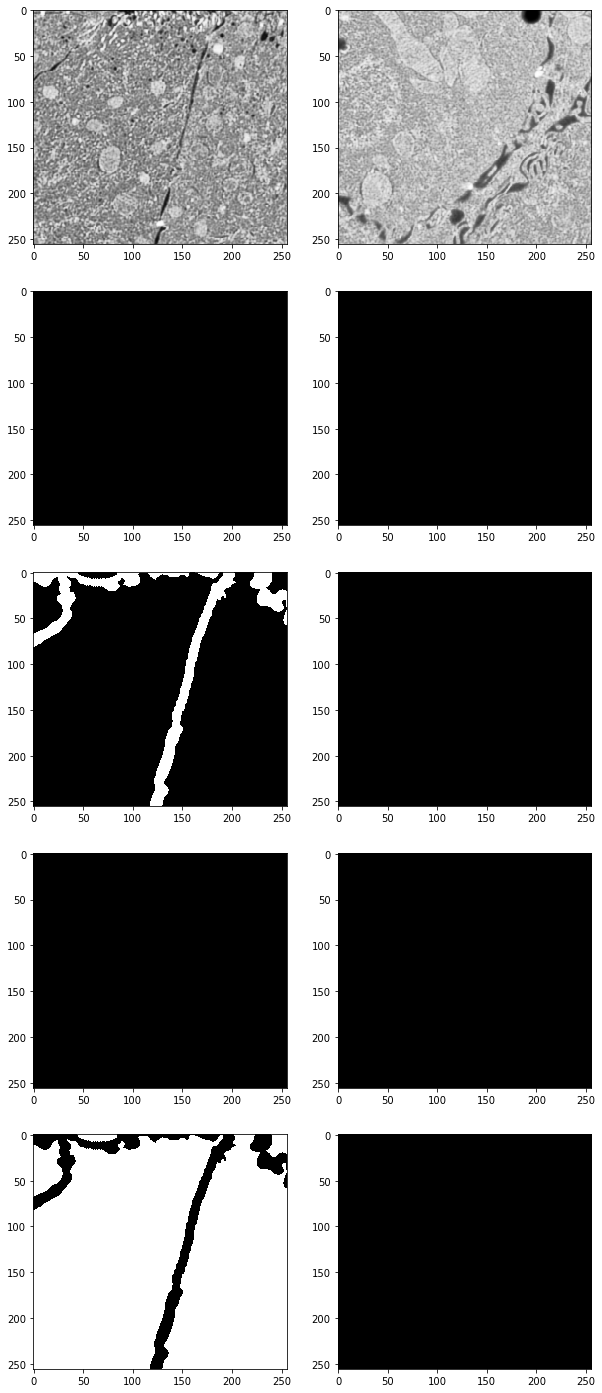

Validation samples


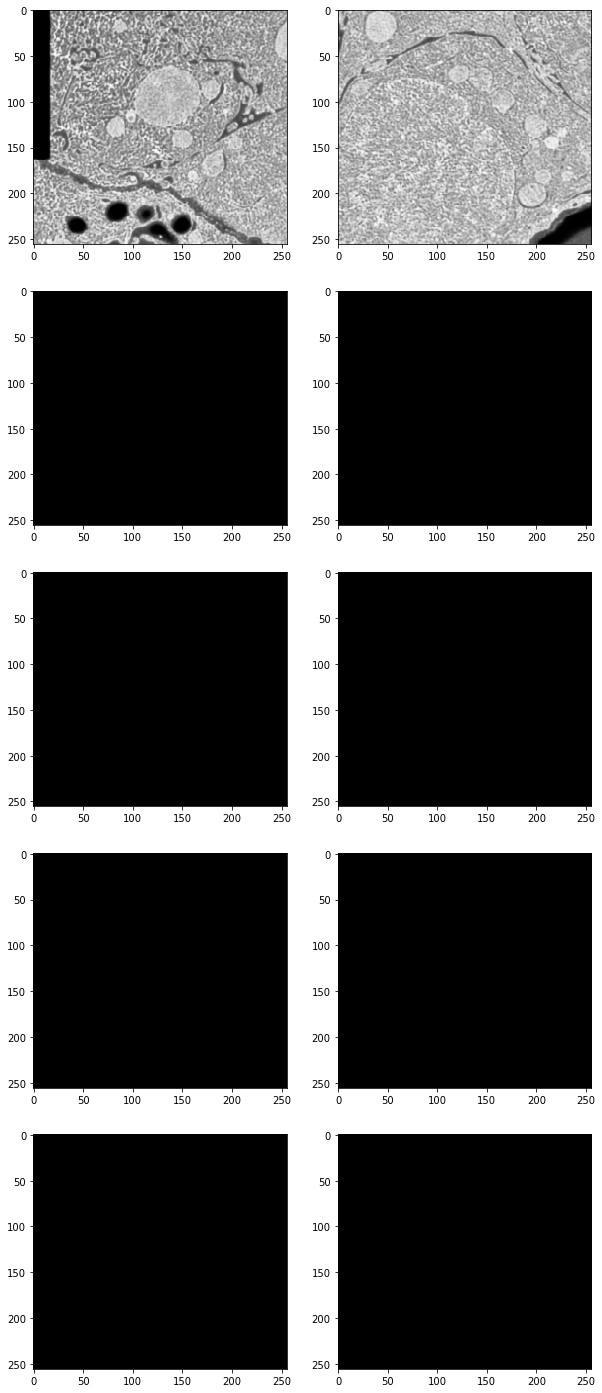

In [44]:
n_samples = 2
use_napari = False

print("Training samples")
check_loader(train_loader, n_samples, plt=not use_napari)
print("Validation samples")
check_loader(val_loader, n_samples, plt=not use_napari)


# Network architecture

Choose the important network architecture parameters for the 2d UNet:

   - `scale_factors`: the down/upscaling factors between each encoder/decoder level. This is specified as a list of 3d scale factors, which enables anisotropic scaling. See the example in the comments for details.
   - `initial_features`: the number of features in the first encoder level, the number will be doubled for each level
   - `final_activation`: the activation applied to the UNet output
   - `in_channels`: the number of input channels (= number of channels of the raw data)
   - `out_channels`: the number of output channels (usually the number of target channels)


In [45]:
# example for 4 levels with anisotropic scaling in the first two levels (scale only in xy)
scale_factors = [[1, 2, 2], [1, 2, 2], [2, 2, 2], [2, 2, 2]]

initial_features = 32
final_activation = "Sigmoid"

in_channels = 1
out_channels = 4

In [46]:
print("Creating 3d UNet with", in_channels, "input channels and", out_channels, "output channels.")
model = AnisotropicUNet(
    in_channels=in_channels, out_channels=out_channels, scale_factors=scale_factors, final_activation=final_activation
)

Creating 3d UNet with 1 input channels and 4 output channels.


# Tensorboard

In [47]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 140541), started 0:26:29 ago. (Use '!kill 140541' to kill it.)

# Training

In [48]:
experiment_name = "default_network"
n_iterations = 10000
learning_rate = 1.0e-4

In [49]:
trainer = torch_em.default_segmentation_trainer(
    name=experiment_name, model=model,
    train_loader=train_loader, val_loader=val_loader,
    loss=loss_function, metric=metric_function,
    learning_rate=learning_rate,
    mixed_precision=True,
    log_image_interval=50
)
trainer.fit(n_iterations)

Start fitting for 10000 iterations /  118 epochs
Training with mixed precision


KeyboardInterrupt: 

Epoch 0:   1%|          | 85/10000 [22:21<43:27:08, 15.78s/it]